# 实验3

实验要求：给定一个数据集和预测任务，需要分析数据以及抽取特征

## 导入模块

In [1]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np


## 数据读取

In [2]:

data = pd.read_csv('exp3.csv',index_col=0)
print(data.head())
print(data.shape)

       queueId  mapId  seasonId  team1_win  team1_firstBlood  \
index                                                          
0          420     11        13          0              True   
1          420     11        13          1             False   
2          420     11        13          0             False   
3          420     11        13          0              True   
4          420     11        13          1              True   

       team1_firstTower  team1_firstInhibitor  team1_firstBaron  \
index                                                             
0                 False                 False             False   
1                  True                  True             False   
2                  True                 False             False   
3                 False                 False             False   
4                  True                  True             False   

       team1_firstDragon  team1_firstRiftHerald  ...  player9_goldEarned  \
index

大致展示得到数据的结构：

In [3]:
# data.info()
# data.describe()

## 数据分析及特征抽取

### 1.比赛特征
**主要工作：** 分析每次比赛的地图、队列、赛季特征。

查看mapId,queueId,seasonId的数据分布，可以看出mapId有两种11和12，其中11个数有70001次，12有999次。
queueId有7中，各自频率如下。
seasonId只有一种取值13,故该特征可直接去除。


In [4]:
print(data['mapId'].value_counts())
print(data['queueId'].value_counts())
print(data['seasonId'].value_counts())
del data['seasonId']

11    79001
12      999
Name: mapId, dtype: int64
420     50146
430     20966
440      4016
700      2594
900      1023
450       999
1020      256
Name: queueId, dtype: int64
13    80000
Name: seasonId, dtype: int64


同时发现有map为12的个数与queue为450的数据个数相同，故猜测queue为450与map为12等价。
下面进行验证。
结果与我们的猜想相同，故mapId也没有意义，可以去掉。

In [5]:
print(all(data[data['mapId']==12]['queueId']==450))
del data['mapId']

True


再来看看queueId与胜负的关系。
可以看出大多数情况的queueId都在420,430之间且基本胜率接近50%，故也可以认为其与胜负关系无关，可以删除。

In [6]:
print(pd.crosstab(data['queueId'],data['team1_win']))
del data['queueId']


team1_win      0      1
queueId                
420        25434  24712
430        11211   9755
440         2488   1528
450          498    501
700         1182   1412
900          517    506
1020         145    111


### 2.队伍特征
**主要任务：** 通过每个队伍的每个选手的数据，组合成队伍的特征(整体经济、整体人头数)，如根据每个人的经济得到队伍经济。

#### 2.1队伍经济分析

In [7]:
# 计算总经济与经济差
data['team1_eco'] = data['player1_goldEarned']+data['player2_goldEarned']+data['player3_goldEarned']+data['player4_goldEarned']+data['player5_goldEarned']
data['team2_eco'] = data['player6_goldEarned']+data['player7_goldEarned']+data['player8_goldEarned']+data['player9_goldEarned']+data['player10_goldEarned']
data['eco_gap'] = data['team1_eco'] - data['team2_eco']

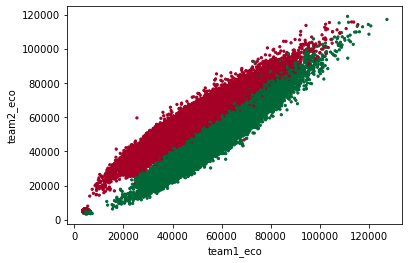

In [8]:
# 画出散点图
# data.plot.scatter(x='team1_eco', y='team2_eco', c='team1_win', colormap='rainbow',colorbar=False)

fig = plt.figure()
axes = fig.add_subplot(111)
plt.scatter(data['team1_eco'], data['team2_eco'], c=data['team1_win'], cmap='RdYlGn', s=5)
plt.xlabel('team1_eco')
plt.ylabel('team2_eco')
plt.show()


获取每个队伍的经济及经济差,画出经济散点图，其中绿色代表team1赢，红色代表team2赢。


In [9]:
#经济是否领先与输赢的关系
eco_gap_positive = data['eco_gap'] > 0
pd.crosstab(data['team1_win'],eco_gap_positive)

eco_gap,False,True
team1_win,,
0,40573,902
1,981,37544


画出经济差正负与胜负关系的列联表，其中eco_gap==True代表经济差(team1-team2)大于0,eco_gap==False反之。根据列联表检验，可以认为游戏胜负与经济是否领先相关。

array([[<AxesSubplot:title={'center':'winner_loser_eco_gap'}>]],
      dtype=object)

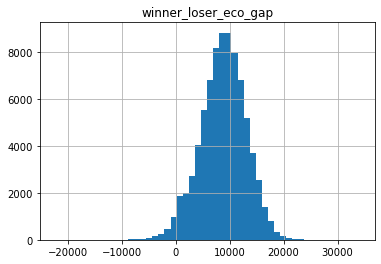

In [10]:
# 所有比赛的胜方与负方经济差分布图，需要统计team1胜利和失败的所有比赛，失败的比赛经济差要取相反数
winner_loser_eco_gap = list(data[data['team1_win']==1]['eco_gap'].values)+list(data[data['team1_win']==0]['eco_gap'].values*(-1))
winner_loser_eco_gap = pd.DataFrame(winner_loser_eco_gap,columns=['winner_loser_eco_gap'])
winner_loser_eco_gap.hist(bins=50)

In [11]:
# 胜方与负方经济差描述图
winner_loser_eco_gap.describe()

,winner_loser_eco_gap
count,80000.000000
mean,8763.360787
std,4207.051713
min,-22459.000000
25%,6110.000000
50%,8914.000000
75%,11610.000000
max,34036.000000


得到胜方与负方经济差分布图及各个统计量，可以看出胜负方经济差大致符合一个正态分布，其均值在8763左右。


**结论：**
* 经济是否领先与胜负相关，且经济高的一方更容易获胜，这也很符合常理。
* 游戏结束时的胜负方经济差大概符合一个均值为8763的正态分布，其各统计量如上图所示。

#### 2.2队伍杀敌数分析

In [12]:
# 计算总人头与人头差
data['team1_kills'] = data['player1_kills']+data['player2_kills']+data['player3_kills']+data['player4_kills']+data['player5_kills']
data['team2_kills'] = data['player6_kills']+data['player7_kills']+data['player8_kills']+data['player9_kills']+data['player10_kills']
data['kills_gap'] = data['team1_kills'] - data['team2_kills']

得到每个队伍的杀敌数及杀敌数差，因杀敌数相对经济更加集中所以没必要画散点图。

In [13]:
# 人头是否领先与输赢的关系
kills_gap_positive = data['kills_gap'] > 0
pd.crosstab(data['team1_win'],kills_gap_positive)

kills_gap,False,True
team1_win,,
0,39327,2148
1,2626,35899


画出人头差正负与胜负关系的列联表，其中kills_gap==True代表经济差(team1-team2)大于0,kills_gap==False反之。根据列联表检验，可以认为游戏胜负与经济是否领先相关。

array([[<AxesSubplot:title={'center':'winner_loser_kills_gap'}>]],
      dtype=object)

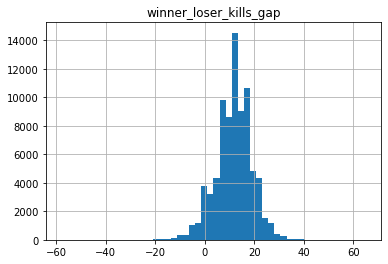

In [14]:
# 所有比赛的胜方与负方人头差分布图，需要统计team1胜利和失败的所有比赛，失败的比赛人头差要取相反数
winner_loser_kills_gap = list(data[data['team1_win']==1]['kills_gap'].values)+list(data[data['team1_win']==0]['kills_gap'].values*(-1))
winner_loser_kills_gap = pd.DataFrame(winner_loser_kills_gap,columns=['winner_loser_kills_gap'])
winner_loser_kills_gap.hist(bins=50)

In [15]:
# 胜方与负方人头差描述图
winner_loser_kills_gap.describe()

,winner_loser_kills_gap
count,80000.000000
mean,11.714688
std,7.353117
min,-58.000000
25%,7.000000
50%,12.000000
75%,16.000000
max,65.000000


得到胜负各方的杀敌数分布图及各个统计量，可以看出胜负方人头差大致符合一个正态分布，其均值在12左右。

**结论：**
* 人头数是否领先与胜负相关，且经济高的一方更容易获胜，这也很符合常理。
* 游戏结束时的胜负方人头差大概符合一个均值为12的正态分布，其各统计量如上图所示。

In [16]:
# all(data[data['player1_lane']=='JUNGLE']['player1_role']=='NONE')
# pd.crosstab(data['player1_lane'],data['player1_role'])

### 3.地图资源特征
**主要任务：** 分析各个地图资源(如1塔，1龙等)特征对胜负的影响，用曼哈顿距离度量两者距离(相关度)，曼哈顿距离即为team1拿了该资源却输了和未拿该资源却赢了的比赛总和。

进行分析前首先进行数据类型转换，将TRUE，FALSE字符类型转换成0，1的int型。

In [17]:
# 类型转换
data.replace(True,1,inplace=True)
data.replace(False,0,inplace=True)
data.head()

,team1_win,team1_firstBlood,team1_firstTower,team1_firstInhibitor,team1_firstBaron,team1_firstDragon,team1_firstRiftHerald,player1_championId,player1_kills,player1_deaths,...,player10_assists,player10_goldEarned,player10_role,player10_lane,team1_eco,team2_eco,eco_gap,team1_kills,team2_kills,kills_gap
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,107,2,4,...,8,8168,DUO,NONE,26720,36199,-9479,9,21,-12
1,1,0,1,1,0,1,1,76,10,5,...,4,6943,DUO_SUPPORT,BOTTOM,52413,41541,10872,32,18,14
2,0,0,1,0,0,1,1,51,7,6,...,1,9685,SOLO,TOP,51296,55630,-4334,14,22,-8
3,0,1,0,0,0,1,0,28,5,3,...,10,13109,SOLO,TOP,47192,51874,-4682,18,23,-5
4,1,1,1,1,0,0,1,79,4,2,...,8,6809,DUO_SUPPORT,BOTTOM,48454,39192,9262,32,19,13


#### 3.1 一血

In [18]:
# 是否拿一血与胜负的关系
pd.crosstab(data['team1_win'],data['team1_firstBlood'])

team1_firstBlood,0,1
team1_win,,
0,24265,17210
1,15162,23363


In [19]:
#计算曼哈顿距离及拿了该资源后的胜率
firstBlood = pd.crosstab(data['team1_win'],data['team1_firstBlood']).values
print(f'Manhattan distance is {firstBlood[0,1]+firstBlood[1,0]}')
print(f'win rate is {firstBlood[1,1]/(firstBlood[0,1]+firstBlood[1,1])}')

Manhattan distance is 32372
win rate is 0.5758262884184063


#### 3.2 一塔

In [20]:
# 是否拿一塔与胜负的关系
pd.crosstab(data['team1_win'],data['team1_firstTower'])

team1_firstTower,0,1
team1_win,,
0,29646,11829
1,10864,27661


In [21]:
# 计算曼哈顿距离及拿了该资源后的胜率
firstTower = pd.crosstab(data['team1_win'],data['team1_firstTower']).values
print(f'Manhattan distance is {firstTower[0,1]+firstTower[1,0]}')
print(f'win rate is {firstTower[1,1]/(firstTower[0,1]+firstTower[1,1])}')

Manhattan distance is 22693
win rate is 0.7004558115978728


#### 3.3 一先锋

In [22]:
# 是否拿一先锋与胜负的关系
pd.crosstab(data['team1_win'],data['team1_firstInhibitor'])

team1_firstInhibitor,0,1
team1_win,,
0,38626,2849
1,11189,27336


In [23]:
# 计算曼哈顿距离及拿了该资源后的胜率
firstInhibitor = pd.crosstab(data['team1_win'],data['team1_firstInhibitor']).values
print(f'Manhattan distance is {firstInhibitor[0,1]+firstInhibitor[1,0]}')
print(f'win rate is {firstInhibitor[1,1]/(firstInhibitor[0,1]+firstInhibitor[1,1])}')

Manhattan distance is 14038
win rate is 0.9056153718734471


#### 3.4 一男爵

In [24]:
# 是否拿一男爵与胜负的关系
pd.crosstab(data['team1_win'],data['team1_firstBaron'])

team1_firstBaron,0,1
team1_win,,
0,37497,3978
1,20144,18381


In [25]:
# 计算曼哈顿距离及拿了该资源后的胜率
firstBaron = pd.crosstab(data['team1_win'],data['team1_firstBaron']).values
print(f'Manhattan distance is {firstBaron[0,1]+firstBaron[1,0]}')
print(f'win rate is {firstBaron[1,1]/(firstBaron[0,1]+firstBaron[1,1])}')

Manhattan distance is 24122
win rate is 0.8220850664162083


#### 3.5 一龙

In [26]:
# 是否拿一龙与胜负的关系
pd.crosstab(data['team1_win'],data['team1_firstDragon'])

team1_firstDragon,0,1
team1_win,,
0,27024,14451
1,15266,23259


In [27]:
# 计算曼哈顿距离及拿了该资源后的胜率
firstDragon = pd.crosstab(data['team1_win'],data['team1_firstDragon']).values
print(f'Manhattan distance is {firstDragon[0,1]+firstDragon[1,0]}')
print(f'win rate is {firstDragon[1,1]/(firstDragon[0,1]+firstDragon[1,1])}')

Manhattan distance is 29717
win rate is 0.6167859984089101


#### 3.6 一水晶

In [28]:
# 是否拿一水晶与胜负的关系
pd.crosstab(data['team1_win'],data['team1_firstRiftHerald'])

team1_firstRiftHerald,0,1
team1_win,,
0,26728,14747
1,16460,22065


In [29]:
# 计算曼哈顿距离及拿了该资源后的胜率
firstRiftHerald = pd.crosstab(data['team1_win'],data['team1_firstRiftHerald']).values
print(f'Manhattan distance is {firstRiftHerald[0,1]+firstRiftHerald[1,0]}')
print(f'win rate is {firstRiftHerald[1,1]/(firstRiftHerald[0,1]+firstRiftHerald[1,1])}')

Manhattan distance is 31207
win rate is 0.5993969357818103


#### 分析：
可以看出拿了地图资源胜率会提高，这在实际中也是显然的。同时也可以发现这些数据中一些有趣的性质。
首先一血、一塔的矩阵正反对角线上的数基本相同，但其他资源的对应矩阵明显有左上大于右下，左下大于右上的性质。
难道team1和team2拿这些资源的胜率有偏差？显然不是，经分析，出现该种状态的原因是**有很多比赛两边都没拿该资源就结束了！！！**
所以左侧数据大于右侧。这时计算拿了该资源后的胜率就比较有意义，现实中lol比赛分析也都如此，会分析拿了某项资源后的胜率。
数据中也有一些反直觉的地方，比如拿了一先锋后的胜率比一大龙的胜率还高，理论上越偏向后期的资源应该对胜率影响越大，**推测比赛数据可能有一定偏差，取的是结束时间较早的数据**，
所以先锋作为前期的重要资源对胜负影响就很大，而两边可能都没打大龙游戏就结束了，所以大龙的影响较小。

最后，根据曼哈顿距离分析，资源与胜负相关度从高到底排序为(距离近的相关度高)：一先锋 > 一塔 > 一男爵 > 一龙 > 一水晶 > 一血。

### 4.英雄及阵容特征
**主要任务：** 分析各英雄与阵容数据，如英雄胜率、英雄常见位置、阵容胜率等。

#### 4.0数据预处理
由于只分析英雄相关数据，故把所有玩家有关英雄的数据合在一张表中，得到championData。

In [30]:
player = 'player' + str(1)
# 生成关于英雄的数据表并展示前几条数据
championList = np.array(data[['team1_win',player+'_championId',player+'_kills',player+'_deaths',player+'_assists',player+'_goldEarned',player+'_role',player+'_lane']].values)
for i in range(1,5):
    player = 'player' + str(i+1)
    playerData = np.array(data[['team1_win',player+'_championId',player+'_kills',player+'_deaths',player+'_assists',player+'_goldEarned',player+'_role',player+'_lane']].values)
    championList = np.concatenate((championList,playerData))
for i in range(5,10):
    player = 'player' + str(i+1)
    playerData = np.array(data[['team1_win',player+'_championId',player+'_kills',player+'_deaths',player+'_assists',player+'_goldEarned',player+'_role',player+'_lane']].values)
    # 对于2队的英雄数据，胜负要反过来
    playerData[:,0] = 1-playerData[:,0]
    championList = np.concatenate((championList,playerData))
championData = pd.DataFrame(championList,columns=['win/lose','championId','kills','deaths','assists','goldEarned','role','lane'])
print(championData)

       win/lose championId kills deaths assists goldEarned         role  \
0             0        107     2      4       0       5385  DUO_SUPPORT   
1             1         76    10      5       6      11865         NONE   
2             0         51     7      6       2      12985    DUO_CARRY   
3             0         28     5      3       5       8953         NONE   
4             1         79     4      2      10       8347         NONE   
...         ...        ...   ...    ...     ...        ...          ...   
799995        1        235     3      5      13       8540  DUO_SUPPORT   
799996        0        157     0      7       4       8248         SOLO   
799997        1          7    10      2      13      11401          DUO   
799998        1        412     1      3       6       5607  DUO_SUPPORT   
799999        1        133     8      5      17      15290         NONE   

          lane  
0         NONE  
1       JUNGLE  
2       BOTTOM  
3       JUNGLE  
4       JUNGLE

#### 4.1英雄胜率分析


In [31]:
# 生成英雄胜率表
champion_win_rate = pd.crosstab(championData['championId'],championData['win/lose'],normalize='index')
# print(champion_win_rate.loc[875].values[1])
# 生成英雄胜率字典
champion_win_rate_dic = {}
for each in champion_win_rate.index:
    champion_win_rate_dic[each] = champion_win_rate.loc[each].values[1]
champion_win_rate = pd.DataFrame([champion_win_rate_dic])
print(champion_win_rate)
win_rate = np.array(champion_win_rate.values)
win_rate_max = max(win_rate[:,1])
print(f"champion max win rate is {win_rate_max}")
win_rate_min = min(win_rate[:,1])
print(f"champion min win rate is {win_rate_min}")

        1         2         3        4         5         6         7    \
0  0.494649  0.492625  0.511351  0.51063  0.494849  0.504712  0.471047   

        8         9         10   ...       429       432       497       498  \
0  0.493365  0.507142  0.481537  ...  0.500113  0.529797  0.491146  0.474113   

        516       517       518      523       555       875  
0  0.490075  0.482556  0.476749  0.48902  0.482339  0.494461  

[1 rows x 148 columns]
champion max win rate is 0.49262467806134397
champion min win rate is 0.49262467806134397


生成英雄的胜率表，通过找到表中胜率最高值与最低值，胜率最高为54%，最低为45%。
由此可见英雄对胜率的影响不算很大，在5%以内，该游戏还算比较平衡。

#### 4.2 lane与role的分析

In [32]:
pd.crosstab(championData['role'],championData['lane'])

lane,BOTTOM,JUNGLE,MIDDLE,NONE,TOP
role,,,,,
DUO,2168,0,26932,23408,13300
DUO_CARRY,117661,0,3753,18,1860
DUO_SUPPORT,118704,0,10358,109144,3875
NONE,0,142264,0,0,0
SOLO,9810,0,107897,0,108848


画出所有的lane与role的关系表，可以看出,role中所有的None的都来自打野选手，而lane中的none有各个角色。
故作出判断role中none是指打野选手并没有具体的角色而lane中的none是因为数据缺失造成的，要进行数据填补，而填补方式是用该英雄大的最多的lane来替换none。
下面进行数据填补，同时得到每个英雄对应最常见lane的字典。

In [33]:
# 填补缺失数据
champion_lane_dict = {}
for each in championData['championId'].unique():
    ds = championData[championData['championId'] == each]['lane'].value_counts().reset_index()
    ds.columns = ['lane', 'count']
    lane = ds.sort_values(['count']).tail(1)['lane'][0]
    championData.loc[(championData['championId'] == each) & (championData['lane'] == 'NONE'),'lane'] = lane
    champion_lane_dict[each] = lane
print(champion_lane_dict)

{107: 'JUNGLE', 76: 'JUNGLE', 51: 'BOTTOM', 28: 'JUNGLE', 79: 'JUNGLE', 555: 'BOTTOM', 145: 'BOTTOM', 127: 'MIDDLE', 98: 'TOP', 119: 'BOTTOM', 8: 'MIDDLE', 245: 'JUNGLE', 4: 'MIDDLE', 16: 'BOTTOM', 523: 'BOTTOM', 15: 'BOTTOM', 238: 'MIDDLE', 54: 'TOP', 267: 'BOTTOM', 58: 'TOP', 80: 'MIDDLE', 9: 'JUNGLE', 44: 'BOTTOM', 421: 'JUNGLE', 41: 'TOP', 32: 'JUNGLE', 74: 'MIDDLE', 81: 'BOTTOM', 91: 'MIDDLE', 31: 'TOP', 875: 'TOP', 111: 'BOTTOM', 266: 'TOP', 254: 'JUNGLE', 86: 'TOP', 89: 'BOTTOM', 412: 'BOTTOM', 142: 'MIDDLE', 39: 'TOP', 30: 'JUNGLE', 90: 'MIDDLE', 235: 'BOTTOM', 24: 'TOP', 59: 'JUNGLE', 2: 'JUNGLE', 55: 'MIDDLE', 157: 'MIDDLE', 34: 'MIDDLE', 18: 'BOTTOM', 517: 'MIDDLE', 120: 'JUNGLE', 122: 'TOP', 26: 'BOTTOM', 99: 'BOTTOM', 105: 'MIDDLE', 22: 'BOTTOM', 56: 'JUNGLE', 7: 'MIDDLE', 11: 'JUNGLE', 42: 'MIDDLE', 114: 'TOP', 43: 'BOTTOM', 37: 'BOTTOM', 19: 'JUNGLE', 75: 'TOP', 21: 'BOTTOM', 117: 'BOTTOM', 202: 'BOTTOM', 35: 'JUNGLE', 62: 'JUNGLE', 222: 'BOTTOM', 23: 'TOP', 236: 'BOTTOM

得到英雄常见lane字典后，对原data表进行补全。

In [34]:
for i in range(10):
    playerChampion = 'player'+str(i+1)+'_championId'
    playerLane = 'player'+str(i+1)+'_lane'
    for each in data[playerChampion].unique():
        data.loc[(data[playerChampion] == each) & (data[playerLane] == 'NONE'),playerLane] = champion_lane_dict[each]
data.head()

,team1_win,team1_firstBlood,team1_firstTower,team1_firstInhibitor,team1_firstBaron,team1_firstDragon,team1_firstRiftHerald,player1_championId,player1_kills,player1_deaths,...,player10_assists,player10_goldEarned,player10_role,player10_lane,team1_eco,team2_eco,eco_gap,team1_kills,team2_kills,kills_gap
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,0,0,107,2,4,...,8,8168,DUO,MIDDLE,26720,36199,-9479,9,21,-12
1,1,0,1,1,0,1,1,76,10,5,...,4,6943,DUO_SUPPORT,BOTTOM,52413,41541,10872,32,18,14
2,0,0,1,0,0,1,1,51,7,6,...,1,9685,SOLO,TOP,51296,55630,-4334,14,22,-8
3,0,1,0,0,0,1,0,28,5,3,...,10,13109,SOLO,TOP,47192,51874,-4682,18,23,-5
4,1,1,1,1,0,0,1,79,4,2,...,8,6809,DUO_SUPPORT,BOTTOM,48454,39192,9262,32,19,13


#### 4.3 类型转换

将英雄，lane，role的类型转换为onehot编码。

In [35]:
# 英雄转换
# team1
champion_onehot_list_all = []
for i in range(5):
    playerChampion = 'player'+str(i+1)+'_championId'
    champion_onehot_list_all.append(pd.get_dummies(data=data[playerChampion],prefix='team1_champion'))
team1_cham_onehot = champion_onehot_list_all[0]
for i in range(1,5):
    team1_cham_onehot = team1_cham_onehot.add(champion_onehot_list_all[i],fill_value=0)
data = pd.concat([data,team1_cham_onehot],axis=1)
# team2
champion_onehot_list_all = []
for i in range(5,10):
    playerChampion = 'player'+str(i+1)+'_championId'
    champion_onehot_list_all.append(pd.get_dummies(data=data[playerChampion],prefix='team2_champion'))
team_cham_onehot = champion_onehot_list_all[0]
for i in range(1,5):
    team_cham_onehot = team_cham_onehot.add(champion_onehot_list_all[i],fill_value=0)
data = pd.concat([data,team_cham_onehot],axis=1)

# role转换
# team1
role_onehot_list_all = []
for i in range(5):
    playerRole = 'player'+str(i+1)+'_role'
    role_onehot_list_all.append(pd.get_dummies(data=data[playerRole],prefix='team1_role'))
team_role_onehot = role_onehot_list_all[0]
for i in range(1,5):
    team_role_onehot = team_role_onehot.add(role_onehot_list_all[i],fill_value=0)
data = pd.concat([data,team_role_onehot],axis=1)
# team2
role_onehot_list_all = []
for i in range(5,10):
    playerRole = 'player'+str(i+1)+'_role'
    role_onehot_list_all.append(pd.get_dummies(data=data[playerRole],prefix='team2_role'))
team_role_onehot = role_onehot_list_all[0]
for i in range(1,5):
    team_role_onehot = team_role_onehot.add(role_onehot_list_all[i],fill_value=0)
data = pd.concat([data,team_role_onehot],axis=1)

# lane转换
# team1
lane_onehot_list_all = []
for i in range(5):
    playerLane = 'player'+str(i+1)+'_lane'
    lane_onehot_list_all.append(pd.get_dummies(data=data[playerLane],prefix='team1_lane'))
team_lane_onehot = lane_onehot_list_all[0]
for i in range(1,5):
    team_lane_onehot = team_lane_onehot.add(lane_onehot_list_all[i],fill_value=0)
data = pd.concat([data,team_lane_onehot],axis=1)
# team2
lane_onehot_list_all = []
for i in range(5,10):
    playerLane = 'player'+str(i+1)+'_lane'
    lane_onehot_list_all.append(pd.get_dummies(data=data[playerLane],prefix='team2_lane'))
team_lane_onehot = lane_onehot_list_all[0]
for i in range(1,5):
    team_lane_onehot = team_lane_onehot.add(lane_onehot_list_all[i],fill_value=0)
data = pd.concat([data,team_lane_onehot],axis=1)


In [36]:
print(data.shape)

(80000, 397)


#### 4.4 得到英雄数据表
对各个英雄数据进行分析，算出登场率，场均人头，场均助攻等场均数据得到一张表，可以用该表衡量英雄各个方面的能力。

In [37]:
# 各英雄出场次数
championFrequency_dic = championData['championId'].value_counts().to_dict()
championFrequency = pd.DataFrame([championFrequency_dic])

print(championFrequency)

     81     412    64     875    145    104    157    517    245    236  ...  \
0  26697  16978  16823  14171  13922  13650  12847  12784  12456  12435  ...   

    32    1     133   77    223   427   85    96   136  72   
0  1708  1682  1538  1360  1331  1247  1236  1214  897  645  

[1 rows x 148 columns]


In [38]:
# 找到每个英雄的场均数据

# 场均击杀
championKills_dic = championData.groupby('championId')['kills'].sum().to_dict()
for key in championKills_dic.keys():
    championKills_dic[key] /= championFrequency_dic[key]
championKills = pd.DataFrame([championKills_dic])
print(championKills)

# 场均助攻
championAssists_dic = championData.groupby('championId')['assists'].sum().to_dict()
for key in championAssists_dic.keys():
    championAssists_dic[key] /= championFrequency_dic[key]
championAssists = pd.DataFrame([championAssists_dic])
print(championAssists)

# 场均死亡
championDeaths_dic = championData.groupby('championId')['deaths'].sum().to_dict()
for key in championDeaths_dic.keys():
    championDeaths_dic[key] /= championFrequency_dic[key]
championDeaths = pd.DataFrame([championDeaths_dic])
print(championDeaths)

# 场均经济
championGold_dic = championData.groupby('championId')['goldEarned'].sum().to_dict()
for key in championGold_dic.keys():
    championGold_dic[key] /= championFrequency_dic[key]
championGold = pd.DataFrame([championGold_dic])
print(championGold)

       1         2         3         4         5         6         7    \
0  5.78478  5.741044  3.935959  4.507515  5.417954  5.703732  6.588901   

        8         9         10   ...       429       432      497       498  \
0  5.268027  4.736158  4.618523  ...  6.731575  2.403537  1.61849  5.702301   

        516       517       518       523      555       875  
0  3.170504  6.274406  4.265186  5.611087  6.18469  4.297297  

[1 rows x 148 columns]
        1         2         3         4         5         6        7    \
0  6.978597  5.959728  9.182315  7.805535  6.822296  4.850358  6.09781   

        8         9         10   ...       429       432        497       498  \
0  5.218703  8.776922  5.652174  ...  5.996619  11.63855  12.442708  6.657958   

        516       517      518       523       555       875  
0  7.645891  6.230288  7.49225  6.221313  7.194454  6.866417  

[1 rows x 148 columns]
        1         2         3         4         5         6         7    \
0  5.

In [39]:
# 得到英雄场均数据表
championData2 = pd.concat([championFrequency,champion_win_rate,championKills,championAssists,championDeaths,championGold],ignore_index=True)
championData2.index=(['Frequency','win_rate','Kills','Assists','Deaths','Gold'])
print(championData2)

                    1             2            3             4            5    \
Frequency   1682.000000   4271.000000  7136.000000   5456.000000  2718.000000   
win_rate       0.494649      0.492625     0.511351      0.510630     0.494849   
Kills          5.784780      5.741044     3.935959      4.507515     5.417954   
Assists        6.978597      5.959728     9.182315      7.805535     6.822296   
Deaths         5.174197      5.031843     4.659613      4.592559     5.527226   
Gold       10097.807372  10509.363381  9370.036155  11077.990103  9987.662987   

                    6             7             8            9    \
Frequency   2653.000000   5388.000000   7988.000000  6231.000000   
win_rate       0.504712      0.471047      0.493365     0.507142   
Kills          5.703732      6.588901      5.268027     4.736158   
Assists        4.850358      6.097810      5.218703     8.776922   
Deaths         4.858651      4.466592      4.684402     5.149414   
Gold       11002.033924 

## 数据存储：

将更改后的特征表存到exp3Data.csv中，得到的英雄数据表存到exp3ChampionData.csv中(见附带文件中的exp3ChampionData.csv文件)。


In [40]:
print(data)

       team1_win  team1_firstBlood  team1_firstTower  team1_firstInhibitor  \
index                                                                        
0              0                 1                 0                     0   
1              1                 0                 1                     1   
2              0                 0                 1                     0   
3              0                 1                 0                     0   
4              1                 1                 1                     1   
...          ...               ...               ...                   ...   
79995          0                 0                 0                     0   
79996          1                 1                 1                     1   
79997          0                 1                 0                     0   
79998          0                 0                 0                     0   
79999          0                 0                 0            

In [41]:
data.to_csv('exp3Data.csv')
championData2.to_csv('exp3ChampionData.csv')